In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import pandas as pd

# extracting NOC codes

url_noc = "https://www.canada.ca/en/immigration-refugees-citizenship/services/immigrate-canada/express-entry/eligibility/find-national-occupation-code.html#wb-auto-4"
chrome_options = Options()
chrome_options.add_experimental_option("detach", True)
driver = webdriver.Chrome(options=chrome_options)
driver.get(url_noc)
time.sleep(5)

num_entries = driver.find_element(By.TAG_NAME, value="select")
num_entries.click()
num_options = driver.find_elements(By.TAG_NAME, value="option")
num_options[-1].click()

dict_data = {}
dict_data["TEER Category"], dict_data["NOC Code"], dict_data["Class Title"] = [[] for i in range(3)]

for i in range(6):

    cells = driver.find_elements(By.CSS_SELECTOR, value="#wb-auto-4 td")
    cells_text = [item.text for item in cells]
    dict_data["TEER Category"] += cells_text[::3]
    dict_data["NOC Code"] += cells_text[1::3]
    dict_data["Class Title"] += cells_text[2::3]

    if i <5:
        next_page = driver.find_element(By.ID, value="wb-auto-4_next")
        next_page.click()

driver.close()
df_noc = pd.DataFrame(dict_data)
df_noc.to_csv("NOC Codes.csv")
df_noc 

,TEER Category,NOC Code,Class Title
0,0,10010,Financial managers
1,0,10011,Human resources managers
2,0,10012,Purchasing managers
3,0,10019,Other administrative services managers
4,0,10020,"Insurance, real estate and financial brokerage..."
...,...,...,...
505,5,95104,Labourers in rubber and plastic products manuf...
506,5,95105,Labourers in textile processing and cutting
507,5,95106,Labourers in food and beverage processing
508,5,95107,Labourers in fish and seafood processing


In [19]:
import numpy as np

# Extracting salaries for noc codes
url = "https://www.jobbank.gc.ca/trend-analysis/search-wages"
chrome_options = Options()
chrome_options.add_experimental_option("detach", True)
driver = webdriver.Chrome(options=chrome_options)
driver.maximize_window()
driver.get(url)
input_box = driver.find_element(By.ID, value="ec-wages:wagesInput")

dict_salaries = {"Job Title":[],
                 "NOC Code":[],
                 "Low ($/hour)": [],
                 "Median ($/hour)": [],
                 "High ($/hour)": [],
                 }

time.sleep(4)
try:
    warning_close =driver.find_element(By.ID, value="j_id_48:outOfCanadaCloseBtn")
    warning_close.click()
    time.sleep(3)
except:
    print("No warning poped up")        

for i in range(len(df_noc)):
    noc_code = df_noc.loc[i]["NOC Code"]
    input_box = driver.find_element(By.ID, value="ec-wages:wagesInput")
    input_box.send_keys(Keys.CONTROL + "a")
    input_box.send_keys(Keys.DELETE)
    input_box.send_keys(noc_code)
    time.sleep(5)
    suggestion = driver.find_element(By.CLASS_NAME, value="tt-selectable")
    suggestion.click()

    if i == 0:
        search_box = driver.find_element(By.NAME, value="ec-wages:j_id_3a")
    else:
        search_box = driver.find_element(By.NAME, value="ec-wages:j_id_2z_4_n") 
        
    search_box.click()
    time.sleep(10)
    job = df_noc.loc[i]["Class Title"]
    toronto_row = driver.find_element(By.XPATH, value='//*[@id="wage-occ-report"]/tbody/tr[48]')
    toronto_cells = toronto_row.find_elements(By.TAG_NAME, value="td")

    try:
        toronto_values = [float(item.text) for item in toronto_cells[:-1]]
    except ValueError:
        print(f"{job} has no value in Toronto")
        toronto_values = [np.nan for item in toronto_cells[:-1]]

    dict_salaries["Job Title"] += [job]
    dict_salaries["NOC Code"] += [noc_code]
    dict_salaries["Low ($/hour)"] += [toronto_values[0]]
    dict_salaries["Median ($/hour)"] += [toronto_values[1]]
    dict_salaries["High ($/hour)"] += [toronto_values[2]]

No warning poped up
Underground mine service and support workers has no value in Toronto
Oil and gas well drilling and related workers and services operators has no value in Toronto
Chain saw and skidder operators has no value in Toronto
Fishing vessel deckhands has no value in Toronto
Rubber processing machine operators and related workers has no value in Toronto
Sawmill machine operators has no value in Toronto
Lumber graders and other wood processing inspectors and graders has no value in Toronto
Other wood processing machine operators has no value in Toronto
Fish and seafood plant workers has no value in Toronto
Other performers has no value in Toronto
Other support occupations in personal services has no value in Toronto
Boat and cable ferry operators and related occupations has no value in Toronto
Aquaculture and marine harvest labourers has no value in Toronto
Trappers and hunters has no value in Toronto
Mine labourers has no value in Toronto
Oil and gas drilling, servicing and 

In [22]:
df_salaries = pd.DataFrame(dict_salaries)
df_salaries.shape

(510, 5)

In [24]:
# Saving salaries data to csv

df_salaries.to_csv("salaries_in_toronto.csv")

In [1]:
# Reading data

import pandas as pd

df_salaries = pd.read_csv("salaries_in_toronto.csv")
df_salaries = df_salaries.drop(["Unnamed: 0"], axis=1)
df_salaries.head() 

,Job Title,NOC Code,Low ($/hour),Median ($/hour),High ($/hour)
0,Financial managers,10010,36.06,57.69,100.00
1,Human resources managers,10011,40.00,55.38,81.73
2,Purchasing managers,10012,38.46,62.78,84.76
3,Other administrative services managers,10019,27.50,45.19,83.07
4,"Insurance, real estate and financial brokerage...",10020,33.65,56.41,96.15


In [2]:
clean_df = df_salaries.dropna()
clean_df.shape

(432, 5)

In [3]:
# Formating the numbers
pd.options.display.float_format = '{:,.0f}'.format

# Select relevant columns from the clean dataframe
df_salaries_yearly = clean_df[["Job Title", "NOC Code"]].copy()

# Define a constant for the number of working hours in a year
HOURS_PER_YEAR = 37.5 * 52

# Convert hourly wages to yearly salaries
df_salaries_yearly[["Low ($/year)", "Median ($/year)", "High ($/year)"]] = (
    clean_df[["Low ($/hour)", "Median ($/hour)", "High ($/hour)"]] * HOURS_PER_YEAR
)

# Display the resulting dataframe
df_salaries_yearly

,Job Title,NOC Code,Low ($/year),Median ($/year),High ($/year)
0,Financial managers,10010,"70,317","112,496","195,000"
1,Human resources managers,10011,"78,000","107,991","159,374"
2,Purchasing managers,10012,"74,997","122,421","165,282"
3,Other administrative services managers,10019,"53,625","88,120","161,986"
4,"Insurance, real estate and financial brokerage...",10020,"65,618","110,000","187,492"
...,...,...,...,...,...
504,"Labourers in wood, pulp and paper processing",95103,"32,272","39,000","49,803"
505,Labourers in rubber and plastic products manuf...,95104,"32,272","36,368","56,550"
506,Labourers in textile processing and cutting,95105,"32,272","35,100","48,750"
507,Labourers in food and beverage processing,95106,"32,272","33,150","42,900"


In [4]:
# Top 10 jobs based on Median salary

# Set pandas option to display full text in cells
pd.set_option('display.max_colwidth', None)

df_salaries_yearly.sort_values(by="Median ($/year)", ascending=False)[:10][["Job Title", "Median ($/year)"]]

,Job Title,Median ($/year)
36,Managers in natural resources production and fishing,"165,438"
106,Lawyers and Quebec notaries,"126,555"
2,Purchasing managers,"122,421"
21,Fire chiefs and senior firefighting officers,"121,076"
107,University professors and lecturers,"120,003"
9,Engineering managers,"120,003"
11,Computer and information systems managers,"120,003"
54,Other professional occupations in physical sciences,"119,067"
13,Government managers - health and social policy development and program administration,"117,858"
10,Architecture and science managers,"117,000"


In [5]:
# Top 10 high potential jobs
df_salaries_yearly.sort_values(by="High ($/year)", ascending=False)[:10][["Job Title", "High ($/year)"]]

,Job Title,High ($/year)
36,Managers in natural resources production and fishing,"1,105,708"
107,University professors and lecturers,"202,508"
277,"Air pilots, flight engineers and flying instructors","195,936"
0,Financial managers,"195,000"
106,Lawyers and Quebec notaries,"193,128"
26,Corporate sales managers,"187,492"
4,"Insurance, real estate and financial brokerage managers","187,492"
45,"Securities agents, investment dealers and brokers","187,492"
11,Computer and information systems managers,"187,492"
10,Architecture and science managers,"181,077"


In [6]:
spread_col = df_salaries_yearly ["High ($/year)"] - df_salaries_yearly["Low ($/year)"]
df_salaries_yearly.insert(2, "Spread", spread_col)
df_salaries_yearly.head()

,Job Title,NOC Code,Spread,Low ($/year),Median ($/year),High ($/year)
0,Financial managers,10010,"124,683","70,317","112,496","195,000"
1,Human resources managers,10011,"81,374","78,000","107,991","159,374"
2,Purchasing managers,10012,"90,285","74,997","122,421","165,282"
3,Other administrative services managers,10019,"108,362","53,625","88,120","161,986"
4,"Insurance, real estate and financial brokerage managers",10020,"121,875","65,618","110,000","187,492"


In [7]:
# Low risk jobs
low_risk = df_salaries_yearly.sort_values(by="Spread")
low_risk[:10]

,Job Title,NOC Code,Spread,Low ($/year),Median ($/year),High ($/year)
467,Cashiers,65100,"1,852","32,272","32,272","34,125"
481,"Dry cleaning, laundry and related occupations",65320,"2,535","32,272","32,272","34,808"
445,"Inspectors and graders, textile, fabric, fur and leather products manufacturing",94133,"4,778","32,272","32,272","37,050"
493,Harvesting labourers,85101,"6,220","32,272","32,272","38,493"
443,"Weavers, knitters and other fabric making occupations",94131,"6,610","32,272","33,150","38,883"
444,Industrial sewing machine operators,94132,"6,728","32,272","32,272","39,000"
472,"Food counter attendants, kitchen helpers and related support occupations",65201,"6,728","32,272","32,272","39,000"
509,"Other labourers in processing, manufacturing and utilities",95109,"9,262","32,272","33,150","41,535"
447,"Industrial butchers and meat cutters, poultry preparers and related workers",94141,"9,750","39,000","41,340","48,750"
507,Labourers in food and beverage processing,95106,"10,628","32,272","33,150","42,900"


In [21]:
"{:,.0f}".format(df_salaries_yearly["Median ($/year)"].mean(numeric_only=True))

'62,124'

In [1]:
df_noc

NameError: name 'df_noc' is not defined

In [12]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import pandas as pd
import numpy as np

# Extracting number of people working in each noc code

df_noc = pd.read_csv("Noc Codes.csv")
df_noc.drop("Unnamed: 0", axis=1, inplace=True)

url = "https://www.jobbank.gc.ca/career-planning/search-job-profile"
chrome_options = Options()
chrome_options.add_experimental_option("detach", True)
driver = webdriver.Chrome(options=chrome_options)
driver.maximize_window()

dict_num_people = {"Job Title":[],
                 "NOC Code":[],
                 "# of working individuals": [],
                 "Prospect": [],
                 }

start = len(dict_num_people["Job Title"])

for i in range(start,len(df_noc)):
    success = False
    driver.get(url)
    if i==start:
        try:
            warning_close =driver.find_element(By.ID, value="j_id_2s:outOfCanadaCloseBtn")
            warning_close.click()
            time.sleep(3)
        except:
            print("No warning poped up")
    while not success:
        try:                                
            time.sleep(3)
            job_input = driver.find_element(By.ID, value="jmr-search:occupationInput")
            noc_code = df_noc.loc[i]["NOC Code"]
            job_input.send_keys(str(noc_code))
            time.sleep(3)
            job_suggestion = driver.find_element(By.CLASS_NAME, value="tt-selectable")
            job_suggestion.click()

            city_input = driver.find_element(By.ID, value="jmr-search:cityPostalCodeInput")
            city_input.send_keys("Toronto")
            time.sleep(3) 
            city_suggestion = driver.find_element(By.XPATH, value='//*[@id="jmr-search"]/div[2]/div/span[1]/div/div/p')
            city_suggestion.click()

            submit_btn = driver.find_element(By.ID, value="searchSubmit")
            submit_btn.click()

            prospect_btn = driver.find_element(By.ID, value="j_id_2n_2_32")
            prospect_btn.click()

            prospect = driver.find_element(By.CLASS_NAME, value="outlooknote").text
            
            bullet_points = driver.find_elements(By.CSS_SELECTOR, value=".col-sm-9 ul li")
            if len(bullet_points) != 0:
                bullet_points = [point.text for point in bullet_points]
                bullet_point = [point for point in bullet_points if "Approximately" in point]
                if len(bullet_point) !=0:
                    num_people = int(bullet_point[0].split()[1].replace(",",""))
                else:
                    num_people = np.nan    
            else:
                num_people = np.nan    

            dict_num_people["Job Title"] += [df_noc.loc[i]["Class Title"]]
            dict_num_people["NOC Code"] += [noc_code]
            dict_num_people["# of working individuals"] += [num_people]
            dict_num_people["Prospect"] += [prospect]
            
            success = True

        except:
            job_input.clear()    
            city_input.clear()
            print(f"Error processing item {i}")            



In [27]:
len(dict_num_people["Prospect"])

510

In [32]:
df_num_people = pd.DataFrame(dict_num_people)
df_num_people.to_csv("num_of_people.csv", index=False)
pd.options.display.float_format = "{:,.0f}".format
df_num_people

,Job Title,NOC Code,# of working individuals,Prospect
0,Financial managers,10010,"19,270",Moderate
1,Human resources managers,10011,"9,030",Good
2,Purchasing managers,10012,"3,080",Good
3,Other administrative services managers,10019,NaN,Undetermined
4,"Insurance, real estate and financial brokerage...",10020,"11,400",Good
...,...,...,...,...
505,Labourers in rubber and plastic products manuf...,95104,"1,580",Moderate
506,Labourers in textile processing and cutting,95105,"1,870",Moderate
507,Labourers in food and beverage processing,95106,"6,980",Moderate
508,Labourers in fish and seafood processing,95107,100,Good


In [33]:
import pandas as pd

df_raw = pd.read_csv("raw saleris.csv")
df_raw.head()

C:\Users\talez\AppData\Local\Temp\ipykernel_17300\2413512283.py:3: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("raw saleris.csv")


,NOC_CNP,NOC_TITLE_ENG,NOC_TITLE_FRA,prov,ER_Code_Code_RE,ER_Name,Nom_RE,Low_Wage_Salaire_Minium,Median_Wage_Salaire_Median,High_Wage_Salaire_Maximal,Average_Wage_Salaire_Moyen,Data_Source_E,Data_Source_F,Reference_Period,Revision_Date_Date_revision,Annual_Wage_Flag_Salaire_annuel,Wage_Comment_E,Wage_Comment_F
0,NOC_00010,Legislators,Membres des corps législatifs,NaN,ER00,Canada,Canada,"31,600","84,000","184,000","97,600",2021 Census,Recensement 2021,2021,2023-11-29,1,Wages for this occupation are presented at an ...,Pour cette profession sont présentés au taux a...
1,NOC_00010,Legislators,Membres des corps législatifs,NL,ER10,Newfoundland and Labrador,Terre-Neuve-et-Labrador,NaN,"99,000",NaN,"90,000",2021 Census,Recensement 2021,2021,2023-11-29,1,Wages for this occupation are presented at an ...,Pour cette profession sont présentés au taux a...
2,NOC_00010,Legislators,Membres des corps législatifs,NL,ER1010,Avalon Peninsula,Avalon Peninsula,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-29,0,NaN,NaN
3,NOC_00010,Legislators,Membres des corps législatifs,NL,ER1020,South Coast--Burin Peninsula,Côte-sud--Burin Peninsula,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-29,0,NaN,NaN
4,NOC_00010,Legislators,Membres des corps législatifs,NL,ER1030,West Coast--Northern Peninsula--Labrador,Côte-ouest--Northern Peninsula--Labrador,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-29,0,NaN,NaN


In [47]:
df_toronto = df_raw[df_raw["ER_Name"] =="Toronto"].copy()
df_toronto.reset_index(inplace=True, drop=True)
df_toronto["NOC_CNP"] = [int(item.split("_")[1]) for item in df_toronto["NOC_CNP"]]
df_toronto.drop(["NOC_TITLE_FRA",
                  "prov",
                    "ER_Code_Code_RE",
                      "ER_Name", "Nom_RE",
                        "Data_Source_F",
                          "Wage_Comment_F",
                          "Data_Source_E",
                          "Reference_Period",
                          "Revision_Date_Date_revision",
                          "Wage_Comment_E"
                          ], axis=1, inplace=True)
df_toronto.rename(columns={"NOC_CNP": "NOC Code",
                            "NOC_TITLE_ENG": "NOC_TITLE",
                             "Low_Wage_Salaire_Minium": "Low_Wage",
                             "Median_Wage_Salaire_Median": "Median_Wage",
                             "High_Wage_Salaire_Maximal": "High_Wage",
                             "Average_Wage_Salaire_Moyen": "Average_Wage",
                             "Annual_Wage_Flag_Salaire_annuel": "Annual_Wage_Flag",
                             }, inplace=True)
pd.options.display.float_format = "{:,.2f}".format
df_toronto.head()

,NOC Code,NOC_TITLE,Low_Wage,Median_Wage,High_Wage,Average_Wage,Annual_Wage_Flag
0,10,Legislators,"50,000.00","119,000.00","204,000.00","126,400.00",1
1,11,Senior government managers and officials,NaN,NaN,NaN,NaN,0
2,12,"Senior managers - financial, communications an...",46.90,85.47,138.46,88.85,0
3,13,"Senior managers - health, education, social an...",NaN,NaN,NaN,NaN,0
4,14,"Senior managers - trade, broadcasting and othe...",25.64,61.54,114.69,65.84,0


In [107]:
df_merged = pd.merge(df_toronto, df_num_people.drop("Job Title", axis=1), on="NOC Code")

# Making all salaries yearly

columns_to_multiply = ["Low_Wage", "Median_Wage", "High_Wage", "Average_Wage"]
multiplier = (37.5 * 52)
rows_to_include = df_merged["Annual_Wage_Flag"] ==0

df_merged.loc[rows_to_include, columns_to_multiply] = df_merged.loc[rows_to_include, columns_to_multiply].multiply(multiplier)
df_merged.drop("Annual_Wage_Flag", axis=1, inplace=True)	

df_merged

,NOC Code,NOC_TITLE,Low_Wage,Median_Wage,High_Wage,Average_Wage,# of working individuals,Prospect
0,10010,Financial managers,"70,317.00","112,495.50","195,000.00","121,816.50","19,270.00",Moderate
1,10011,Human resources managers,"78,000.00","107,991.00","159,373.50","115,459.50","9,030.00",Good
2,10012,Purchasing managers,"74,997.00","122,421.00","165,282.00","122,460.00","3,080.00",Good
3,10019,Other administrative services managers,"53,625.00","88,120.50","161,986.50","101,380.50",NaN,Undetermined
4,10020,"Insurance, real estate and financial brokerage...","65,617.50","109,999.50","187,492.50","121,446.00","11,400.00",Good
...,...,...,...,...,...,...,...,...
505,95104,Labourers in rubber and plastic products manuf...,"32,272.50","36,367.50","56,550.00","38,122.50","1,580.00",Moderate
506,95105,Labourers in textile processing and cutting,"32,272.50","35,100.00","48,750.00","37,771.50","1,870.00",Moderate
507,95106,Labourers in food and beverage processing,"32,272.50","33,150.00","42,900.00","34,768.50","6,980.00",Moderate
508,95107,Labourers in fish and seafood processing,NaN,NaN,NaN,NaN,100.00,Good


In [111]:
# jobs with very good prospect

df_merged[df_merged["Prospect"] == "Very good"].sort_values(by="Median_Wage", ascending=False)[:10]

,NOC Code,NOC_TITLE,Low_Wage,Median_Wage,High_Wage,Average_Wage,# of working individuals,Prospect
60,20010,Engineering managers,"84,006.00","120,003.00","165,750.00","120,042.00","8,660.00",Very good
174,40021,School principals and administrators of elemen...,"74,997.00","107,250.00","131,254.50","105,124.50","5,430.00",Very good
443,90011,Utilities managers,"74,997.00","106,528.50","146,250.00","107,347.50","1,590.00",Very good
131,31110,Dentists,"35,320.00","100,000.00","200,000.00","116,700.00","6,090.00",Very good
65,21102,Geoscientists and oceanographers,"77,337.00","99,996.00","154,693.50","101,185.50",790.00,Very good
173,40020,Administrators - post-secondary education and ...,"66,670.50","98,436.00","139,288.50","107,152.50","3,510.00",Very good
130,31103,Veterinarians,"32,272.50","98,436.00","177,274.50","106,411.50","1,960.00",Very good
63,21100,Physicists and astronomers,"70,005.00","97,500.00","169,650.00","104,481.00",460.00,Very good
98,21399,Other professional engineers,"46,800.00","89,992.50","156,565.50","92,157.00","6,950.00",Very good
372,72601,Air traffic controllers and related occupations,"39,000.00","87,750.00","144,222.00","90,831.00",NaN,Very good


In [112]:
df_clean = df_merged.dropna()
df_clean.shape

(391, 8)

In [113]:
average = sum(df_clean["# of working individuals"] * df_clean["Average_Wage"])/sum(df_clean["# of working individuals"])
average

65518.51724332663

In [26]:
# You can modify the code for Canada wide salaries 

job = df_noc.loc[0]["Class Title"]

national_row = driver.find_element(By.CLASS_NAME, value="wage-national")
national_cells = national_row.find_elements(By.TAG_NAME, value="td")
national_values = [float(item.text) for item in national_cells[:-1]]
national_values

[33.62, 55.29, 87.91]

In [34]:
# You can modify the code for salaries in Montreal

montreal_row = driver.find_element(By.XPATH, value='//*[@id="wage-occ-report"]/tbody/tr[33]')
montreal_cells = montreal_row.find_elements(By.TAG_NAME, value="td")
montreal_values = [float(item.text) for item in montreal_cells[:-1]]
montreal_values

[32.0, 52.88, 82.42]

In [35]:
# You can modify the code for salaries in Vancouver

vancouver_row = driver.find_element(By.XPATH, value='//*[@id="wage-occ-report"]/tbody/tr[83]')
vancouver_cells = vancouver_row.find_elements(By.TAG_NAME, value="td")
vancouver_values = [float(item.text) for item in vancouver_cells[:-1]]
vancouver_values

[23.0, 50.0, 72.12]

In [36]:
# You can modify the code for salaries in Ottawa

ottawa_row = driver.find_element(By.XPATH, value='//*[@id="wage-occ-report"]/tbody/tr[46]')
ottawa_cells = ottawa_row.find_elements(By.TAG_NAME, value="td")
ottawa_values = [float(item.text) for item in ottawa_cells[:-1]]
ottawa_values

[43.59, 60.1, 92.31]

In [46]:
# Ontario Public Sector Salaries discloused 2023

import pandas as pd



df_pss = pd.read_csv("tbs-pssd-compendium-salary-disclosed-2023.csv")
df_pss.sort_values(by=" Salary ", inplace=True, ignore_index=True)
# df_pss[' Salary '] = df_pss.apply(lambda x: "{:,}".format(x[' Salary ']), axis=1)
df_pss.head()

,Sector,Last Name,First Name,Salary,Benefits,Employer,JobTitle,Year
0,Other Public Sector Employers,Skrobos,Sébastien,100000,19612,L'equipe D'hygiene Mentale Pour Francophones D...,Directeur génerale/ Executive director,2023
1,School Boards,Cosentino,Jeffrey,100000,-,Halton Catholic District School Board,"Teacher, Secondary",2023
2,School Boards,Zlomislic-Benko,Margaret,100000,100,Niagara Catholic District School Board,Secondary Teacher,2023
3,Government of Ontario - Ministries,Hoffmeister,Matt,100000,210,"Environment, Conservation and Parks / Environn...",Environmental Compliance Officer / Agent de la...,2023
4,Other Public Sector Employers,Colandrea,Camilla,100000,-,Interior Finishing Systems Training Centre,Training Coordinator,2023


In [47]:
count = (df_pss.index + 1) / len(df_pss)
df_pss.insert(5, "Percentage", count)
df_pss.head()

,Sector,Last Name,First Name,Salary,Benefits,Percentage,Employer,JobTitle,Year
0,Other Public Sector Employers,Skrobos,Sébastien,100000,19612,3.327012010513358e-06,L'equipe D'hygiene Mentale Pour Francophones D...,Directeur génerale/ Executive director,2023
1,School Boards,Cosentino,Jeffrey,100000,-,6.654024021026716e-06,Halton Catholic District School Board,"Teacher, Secondary",2023
2,School Boards,Zlomislic-Benko,Margaret,100000,100,9.981036031540073e-06,Niagara Catholic District School Board,Secondary Teacher,2023
3,Government of Ontario - Ministries,Hoffmeister,Matt,100000,210,1.3308048042053432e-05,"Environment, Conservation and Parks / Environn...",Environmental Compliance Officer / Agent de la...,2023
4,Other Public Sector Employers,Colandrea,Camilla,100000,-,1.663506005256679e-05,Interior Finishing Systems Training Centre,Training Coordinator,2023


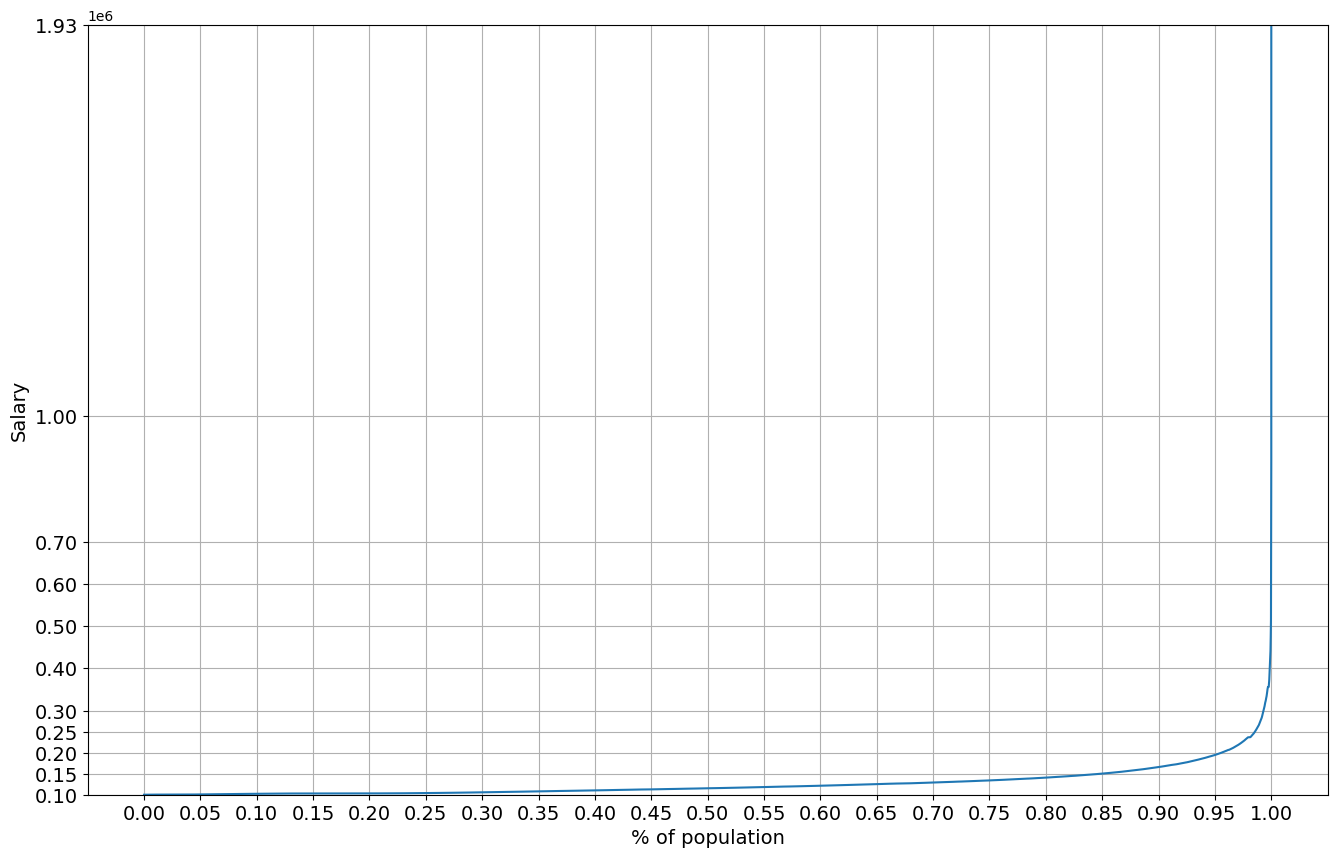

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("% of population", fontsize=14)
plt.ylabel("Salary", fontsize=14)
plt.ylim(100000, 1930000)
plt.xticks(ticks=(np.array(range(0,101, 5)))/100)
plt.yticks(ticks=[100000, 150000, 200000, 250000, 300000, 400000, 500000, 600000, 700000, 1000000, 1930000])
plt.grid()
plt.plot(df_pss["Percentage"], df_pss[" Salary "])

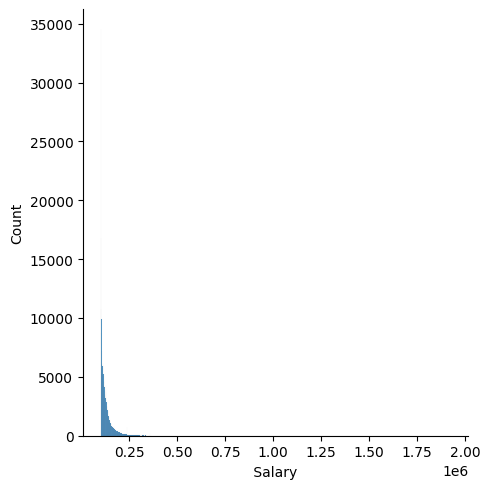

In [63]:
import seaborn as sns

sns.displot(df_pss, x=" Salary ")